# Astropy Remapping Testing
- Test how good the remapping of pixels (and constituent corners) is using the simple astropy pixel to world and world to pixel functions

In [3]:
import matplotlib.pyplot as plt
from astropy.wcs import WCS
from astropy import wcs
import astropy.units as u
import astropy.convolution as convolution
from astropy.coordinates import SkyCoord
import numpy as np
import sunpy.data.sample
import sunpy.map
from sunpy.coordinates import HeliographicCarrington, HeliographicStonyhurst, Heliocentric, Helioprojective, frames
from astropy.io import fits
import matplotlib.colors
from scipy import signal
from scipy import misc
import math
import json
import matplotlib as mpl
import sunpy.visualization.colormaps as cm
magmap = mpl.colormaps['hmimag']

/scratch/slam/sinjan/.conda/envs/p310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### load HRT arlongterm test data - one on the first day of arlongterm, and one (later) on the last day

- blos and icnt

In [4]:
# 12-10-23

#load HRT first blos
filedir = '/data/solo/phi/data/fmdb/public/l2/2023-10-12/'
bfile = 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz'
icfile = 'solo_L2_phi-hrt-icnt_20231012T001503_V202408291137_0350120601.fits.gz'

hrt_121023_b = fits.getdata(filedir+bfile)
hrt_121023_b_hdr = fits.getheader(filedir+bfile)

hrt_121023_ic = fits.getdata(filedir+icfile)
hrt_121023_ic_hdr = fits.getheader(filedir+icfile)

print(hrt_121023_b_hdr['CRPIX1'])
print(hrt_121023_b_hdr['CRPIX2'])
print(hrt_121023_b_hdr['CRVAL1'])
print(hrt_121023_b_hdr['CRVAL2'])

1109.117
755.6157
338.6472
387.539


### correct the WCS keywords

In [5]:
#load 12-10-23 wcs correction
with open('/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRVAL_corrections_20231012.json') as f:
    hrt_121023_wcs_err = json.load(f)

In [6]:
fileDID = hrt_121023_b_hdr['PHIDATID']

In [7]:
crval_err = hrt_121023_wcs_err[fileDID]

In [8]:
crval_err

[-1.934214925750382, 113.7871115449891]

In [9]:
hrt_121023_b_hdr['CRVAL1']

338.6472

In [10]:
#correct CRVAL keywords
crval_errx = crval_err[0]
crval_erry = crval_err[1]

hrt_121023_b_hdr['CRVAL1'] = hrt_121023_b_hdr['CRVAL1']-crval_errx
hrt_121023_b_hdr['CRVAL2'] = hrt_121023_b_hdr['CRVAL2']-crval_erry

hrt_121023_ic_hdr['CRVAL1'] = hrt_121023_ic_hdr['CRVAL1']-crval_errx
hrt_121023_ic_hdr['CRVAL2'] = hrt_121023_ic_hdr['CRVAL2']-crval_erry

In [11]:
hrt_121023_b_hdr

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 1792 / number of pixels on the x axis                 
NAXIS2  =                 1792 / number of pixels on the y axis                 
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
LONGSTRN= 'OGIP 1.0'           / The HEASARC Long String Convention may be used.
COMMENT   This FITS file may contain long string keyword values that are        
COMMENT   continued over multiple keywords.  The HEASARC convention uses the &  
COMMENT   character at the end of each substring which is then continued        
COMMENT   on the next keywor

In [12]:
hrt_121023_b_map_shifttest = sunpy.map.Map(filedir+bfile)
hrt_121023_b_map_shifttest.reference_coordinate

<SkyCoord (Helioprojective: obstime=2023-10-12T00:15:03.293, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:15:03.293, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-78.266917, 1.8157965, 4.66449761e+10)>): (Tx, Ty) in arcsec
    (338.6472, 387.539)>

In [13]:
crval_errx_arcsec=-crval_errx*u.arcsec
crval_erry_arcsec=-crval_erry*u.arcsec
hrt_121023_b_map_shifttestn=hrt_121023_b_map_shifttest.shift_reference_coord(crval_errx_arcsec.to(u.deg),crval_erry_arcsec.to(u.deg))
print("Added items:", hrt_121023_b_map_shifttestn.meta.added_items)
print("Removed items:", hrt_121023_b_map_shifttestn.meta.removed_items)
print("Modified items:", hrt_121023_b_map_shifttestn.meta.modified_items)

Added items: {}
Removed items: {}
Modified items: {'crval2': (original=387.539, current=273.7518884550109), 'crval1': (original=338.6472, current=340.5814149257504)}


In [15]:
hrt_121023_b_map_shifttest.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.094068666666667 0.10764972222222 
CRPIX : 1109.117 755.6157 
PC1_1 PC1_2  : 0.9907795 -0.1354844 
PC2_1 PC2_2  : 0.1354844 0.9907795 
CDELT : 0.00013888888888889 0.00013888888888889 
NAXIS : 1792  1792

In [14]:
hrt_121023_b_map_shifttestn.wcs

WCS Keywords

Number of WCS axes: 2
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 
CRVAL : 0.094605948590486 0.076042191237503 
CRPIX : 1109.117 755.6157 
PC1_1 PC1_2  : 0.9907795 -0.1354844 
PC2_1 PC2_2  : 0.1354844 0.9907795 
CDELT : 0.00013888888888889 0.00013888888888889 
NAXIS : 1792  1792

In [60]:
hrt_121023_b_map_shifttest.reference_coordinate

<SkyCoord (Helioprojective: obstime=2023-10-12T00:15:03.293, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:15:03.293, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
    (-78.266917, 1.8157965, 4.66449761e+10)>): (Tx, Ty) in arcsec
    (338.6472, 387.539)>

In [61]:
crval_errx_arcsec.to(u.deg)

<Quantity 0.00053728 deg>

In [62]:
crval_erry_arcsec.to(u.deg)

<Quantity -0.03160753 deg>

In [63]:
hrt_121023_b_map_shifttest.meta

MetaDict([('simple': 'True')
('bitpix': '-32')
('naxis': '2')
('naxis1': '1792')
('naxis2': '1792')
('extend': 'True')
('comment': 'FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
  This FITS file may contain long string keyword values that are
  continued over multiple keywords.  The HEASARC convention uses the &
  character at the end of each substring which is then continued
  on the next keyword which has the name CONTINUE.')
('longstrn': 'OGIP 1.0')
('filename': 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz')
('date': '2024-08-29T14:34:12')
('': '
  / Instrument and observation configuration FITS keywords

  / Description of data content keywords

  / Image relative to detector electronics keywords

  / Onboard processing keywords

  / WCS keywords

  / Solar Ephemeris Data

  / PHI_FITS_DPU_prehk

  / PHI_FITS_PCM_prehk

  / PHI_FITS_MECH_prehk

  / PHI_FITS_TEM

In [64]:
with open('/data/slam/sinjan/arlongterm_hrt_wcs_corr/hrt_CRPIX_corrections_20231012.json') as f:
    hrt_121023_wcs_err_crpix = json.load(f)

crpix_err = hrt_121023_wcs_err_crpix[fileDID]

In [65]:
crpix_err

[27, 226]

In [66]:
hrt_121023_b_hdr['CRPIX1']

1109.117

In [67]:
#correct CRPIX keywords
crpix_errx = crpix_err[0]
crpix_erry = crpix_err[1]

hrt_121023_b_hdr['CRPIX1'] = hrt_121023_b_hdr['CRPIX1']-crpix_errx
hrt_121023_b_hdr['CRPIX2'] = hrt_121023_b_hdr['CRPIX2']-crpix_erry

hrt_121023_ic_hdr['CRPIX1'] = hrt_121023_ic_hdr['CRPIX1']-crpix_errx
hrt_121023_ic_hdr['CRPIX2'] = hrt_121023_ic_hdr['CRPIX2']-crpix_erry

In [68]:
hrt_121023_b_hdr['CRPIX1']

1082.117

### load the HMI file (blos and ic_45s)

In [69]:
hmifiledir = '/scratch/slam/sinjan/arlongterm_hmi/'
hmibfile = 'blos_45/hmi.m_45s.20231012_002145_TAI.2.magnetogram.fits'
hmiicfile = 'ic_45/hmi.ic_45s.20231012_002145_TAI.2.continuum.fits'

#must rotate the HMI files
hmi_121023_b = sunpy.map.Map(hmifiledir+hmibfile).rotate()
hmi_121023_b_hdr = hmi_121023_b.meta

hmi_121023_ic = sunpy.map.Map(hmifiledir+hmiicfile).rotate()
hmi_121023_ic_hdr = hmi_121023_ic.meta

### plot both to confirm

In [70]:
hpc_coords = sunpy.map.all_coordinates_from_map(hmi_121023_b)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)

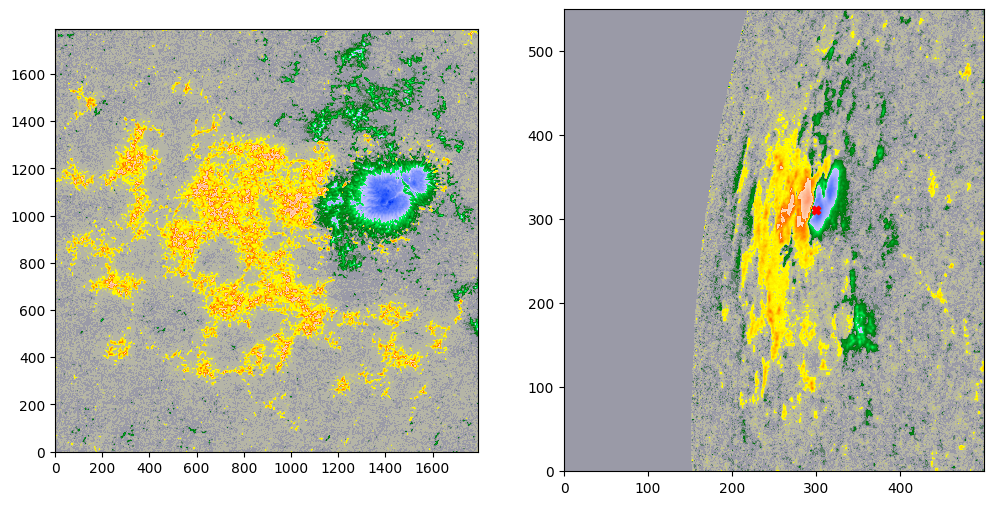

In [71]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

plt.subplot(122)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
plt.imshow(hmi_121023_b.data[2000:2550,:500]*~mask[2000:2550,:500],origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.scatter(300,310,marker='X',color='red')
plt.show()

### Running Alex's Code 'Meshgrid example'

- Remap HMI pixel onto HRT, as HMI is the larger pixel size


```python
#############Example using meshgrid

# Map shape
ny_phi, nx_phi = phi_map.data.shape
ny_hmi, nx_hmi = hmi_map.data.shape

# Create a pixel grid
x_pixels_hmi, y_pixels_hmi = np.arange(nx_hmi), np.arange(ny_hmi)
x_hmi, y_hmi = np.meshgrid(x_pixels_hmi, y_pixels_hmi)

x_pixels_phi, y_pixels_phi = np.arange(nx_phi), np.arange(ny_phi)
x_phi, y_phi = np.meshgrid(x_pixels_phi, y_pixels_phi)


# Central coordinates of each pixel in Stonyhurst (lat/lon grid)
central_coords_hmi = hmi_map.pixel_to_world(x_hmi * u.pixel, y_hmi * u.phi).transform_to(HeliographicStonyhurst(obstime=hmi_map.date))
central_coords_phi = phi_map.pixel_to_world(x_phi * u.phi, y_phi * u.pixel).transform_to(HeliographicStonyhurst(obstime=phi_map.date))
# Bottom-left coordinates of each pixel in Stonyhurst (lat/lon grid)
bottom_left_coords_hmi = hmi_map.pixel_to_world((x_hmi - 0.5) * u.pixel, (y_hmi - 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=hmi_map.date))
bottom_left_coords_phi = phi_map.pixel_to_world((x_phi - 0.5) * u.pixel, (y_phi - 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=phi_map.date))
# Top-right coordinates of each pixel in Stonyhurst (lat/lon grid)
top_right_coords_hmi = hmi_map.pixel_to_world((x_hmi + 0.5) * u.pixel, (y_hmi + 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=hmi_map.date))
top_right_coords_phi = phi_map.pixel_to_world((x_phi + 0.5) * u.pixel, (y_phi + 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=phi_map.date))
```

### Remap one HMI sunspot umbra pixel onto HRT blos

#Stuck at lunchtime on 14 Jan

#issue with the calculated coord in PHI map at the end, I think I need to correct the meta info in the HRT sunpy map
#tried modifying the CRVAL keywords in the PHI sunpy map, but it does not seem to modify anything
#the error in the pixel seems to be equivalent to the calculated error in CRPIX, hence my thinking
#tried looking at the source code for the world_to_pixel method, but it seems very complicated due to mulitple layers (wrapper of astropy methods)
#almost impossible to figure out directly which sunpy meta keyword is the critical one
#from trial and error and trying to create a wcs header object from the fits header, it seems the reference coordinate is the key one - hence my above attempts to shift the ref coord

In [72]:
x_hmi=300
y_hmi=2310

In [73]:
central_coord_hmi = hmi_121023_b.pixel_to_world(x_hmi*u.pixel,y_hmi*u.pixel).transform_to(HeliographicStonyhurst(obstime=hmi_121023_b.date))
bottom_left_coord_hmi = hmi_121023_b.pixel_to_world((x_hmi - 0.5) * u.pixel, (y_hmi - 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=hmi_121023_b.date))
top_right_coord_hmi = hmi_121023_b.pixel_to_world((x_hmi + 0.5) * u.pixel, (y_hmi + 0.5) * u.pixel).transform_to(HeliographicStonyhurst(obstime=hmi_121023_b.date))

In [42]:
central_coord_hmi

<SkyCoord (HeliographicStonyhurst: obstime=2023-10-12T00:20:44.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-69.25926635, 10.08816777, 6.96e+08)>

In [44]:
bottom_left_coord_hmi

<SkyCoord (HeliographicStonyhurst: obstime=2023-10-12T00:20:44.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-69.29391907, 10.06951883, 6.96e+08)>

In [45]:
top_right_coord_hmi

<SkyCoord (HeliographicStonyhurst: obstime=2023-10-12T00:20:44.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-69.22467872, 10.10680984, 6.96e+08)>

In [74]:
world_centre = hmi_121023_b.pixel_to_world(x_hmi*u.pixel,y_hmi*u.pixel)
world_centre

<SkyCoord (Helioprojective: obstime=2023-10-12T00:20:44.600, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2023-10-12T00:20:44.600, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
    (-0.01817826, 6.12642574, 1.49338581e+11)>): (Tx, Ty) in arcsec
    (-886.50730847, 131.84706627)>

In [75]:
phi_centre_pix = hrt_121023_b_map_shifttestn.world_to_pixel(world_centre)
phi_centre_pix

PixelPair(x=<Quantity 1435.55724325 pix>, y=<Quantity 1066.77883282 pix>)

In [76]:
phi_bleft_pix = hrt_121023_b_map_shifttestn.world_to_pixel(bottom_left_coord_hmi)
phi_bleft_pix

PixelPair(x=<Quantity 1431.69954063 pix>, y=<Quantity 1065.2590572 pix>)

In [77]:
phi_tright_pix = hrt_121023_b_map_shifttestn.world_to_pixel(top_right_coord_hmi)
phi_tright_pix

PixelPair(x=<Quantity 1439.40712951 pix>, y=<Quantity 1068.29885456 pix>)

In [78]:
phi_centre_pix.y.value

1066.7788328198837

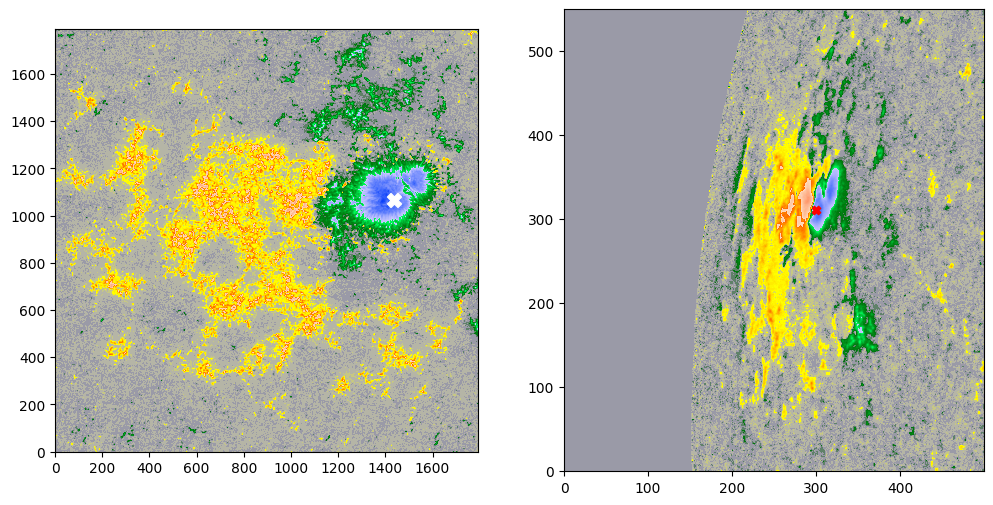

In [79]:
plt.figure(figsize=(12,6))
plt.subplot(121)
plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.scatter(int(round(phi_centre_pix.x.value,0)),int(round(phi_centre_pix.y.value,0)),marker='X',color='white',s=100)

plt.subplot(122)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
plt.imshow(hmi_121023_b.data[2000:2550,:500]*~mask[2000:2550,:500],origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
plt.scatter(300,310,marker='X',color='red')
plt.show()

841.126319116694
[[1256.9921 1239.704  1247.3054 1188.5177 1211.7212 1126.7488 1123.3969
  1133.6842]
 [1281.4839 1369.8636 1387.3528 1266.7485 1195.272  1163.4869 1151.0337
  1122.2183]
 [1240.4453 1288.9451 1304.4966 1294.226  1191.3247 1208.4907 1108.1475
  1118.1217]
 [1121.518  1344.941  1386.1893 1227.5315 1122.1743 1117.5905 1106.2964
  1143.5854]]
1212.1736 85.71577


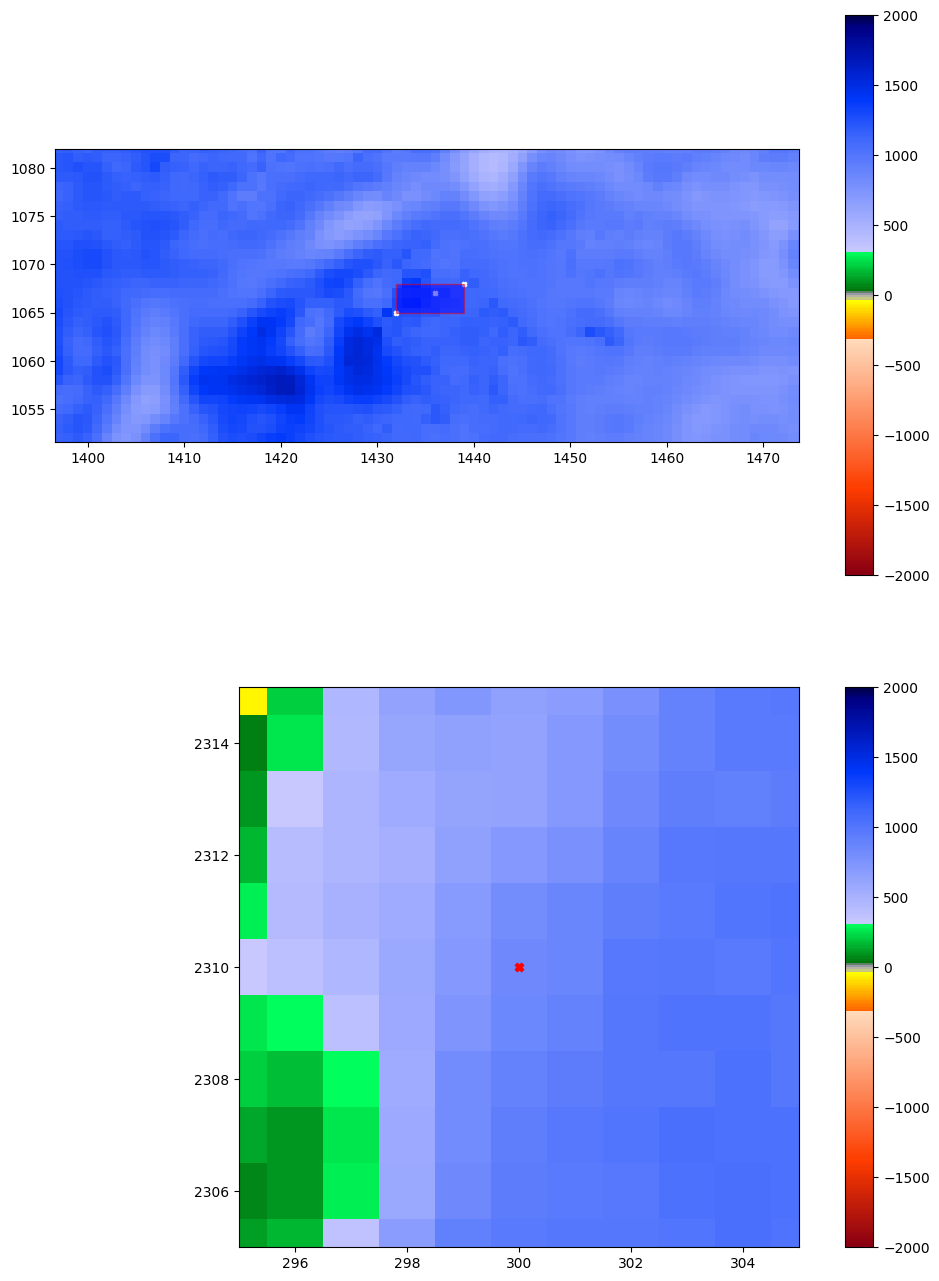

In [81]:
import matplotlib.patches as patches

plt.figure(figsize=(12,16))
plt.subplot(211)
im=plt.imshow(hrt_121023_b,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)
cx=int(round(phi_centre_pix.x.value,0))
cy=int(round(phi_centre_pix.y.value,0))
blx=int(round(phi_bleft_pix.x.value,0))
bly=int(round(phi_bleft_pix.y.value,0))
trx=int(round(phi_tright_pix.x.value,0))
tryy=int(round(phi_tright_pix.y.value,0))
plt.scatter(cx,cy,marker='X',color='white',s=10)
plt.scatter(blx,bly,marker='X',color='white',s=10)
plt.scatter(trx,tryy,marker='X',color='white',s=10)

ax=plt.gca()
rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, edgecolor='r', facecolor='blue', alpha=0.5)
ax.add_patch(rect)

blhmi=hmi_121023_b.pixel_to_world((x_hmi-5)*u.pixel,(y_hmi-5)*u.pixel)
trhmi=hmi_121023_b.pixel_to_world((x_hmi+5)*u.pixel,(y_hmi+5)*u.pixel)

blhrt=hrt_121023_b_map_shifttestn.world_to_pixel(blhmi)
trhrt=hrt_121023_b_map_shifttestn.world_to_pixel(trhmi)
plt.colorbar(im)
plt.ylim(blhrt.y.value,trhrt.y.value)
plt.xlim(blhrt.x.value,trhrt.x.value)

plt.subplot(212)
hmi_121023_b.data[np.isnan(hmi_121023_b.data)]=0
im2=plt.imshow(hmi_121023_b.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
plt.scatter(300,2310,marker='X',color='red')
plt.colorbar(im2)
plt.ylim(y_hmi-5,y_hmi+5)
plt.xlim(x_hmi-5,x_hmi+5)

print(hmi_121023_b.data[y_hmi,x_hmi])
print(hrt_121023_b[bly:tryy+1,blx:trx+1])
print(np.mean(hrt_121023_b[bly:tryy+1,blx:trx+1]),np.std(hrt_121023_b[bly:tryy+1,blx:trx+1]))

plt.show()

In [158]:
#TODO

#repeat for neighbouring pixels, see if overlaps
#compare with reproject

In [82]:
#function for neighbouring pixels
#hmi_121023_b
def get_phi_pixels_from_hmi_pixel(hmi_map,phi_map,x_hmi,y_hmi):
    central_coord_hmi = hmi_map.pixel_to_world(x_hmi*u.pixel,y_hmi*u.pixel)
    bleft_coord_hmi = hmi_map.pixel_to_world((x_hmi - 0.5) * u.pixel, (y_hmi - 0.5) * u.pixel)
    tright_coord_hmi = hmi_map.pixel_to_world((x_hmi + 0.5) * u.pixel, (y_hmi + 0.5) * u.pixel)

    central_coord_phi = phi_map.world_to_pixel(central_coord_hmi)
    bleft_coord_phi = phi_map.world_to_pixel(bleft_coord_hmi)
    tright_coord_phi = phi_map.world_to_pixel(tright_coord_hmi)

    return central_coord_phi,bleft_coord_phi,tright_coord_phi

In [83]:
def get_phi_pixels_and_neighbours(hmi_map,phi_map,x_hmi,y_hmi,neighbour_length):
    phi_out_dicts = {}
    for x_offset in range(-neighbour_length,neighbour_length+1):
        neigh_x = int(x_hmi + x_offset)
        for y_offset in range(-neighbour_length,neighbour_length+1):
            neigh_y = int(y_hmi + y_offset)
            phi_centre,phi_bleft,phi_tright = get_phi_pixels_from_hmi_pixel(hmi_map,phi_map,neigh_x,neigh_y)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} centre']=(phi_centre.x.value,phi_centre.y.value)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} bleft']=(phi_bleft.x.value,phi_bleft.y.value)
            phi_out_dicts[f'HMI {(neigh_x,neigh_y)} tright']=(phi_tright.x.value,phi_tright.y.value)

    return phi_out_dicts

In [86]:
phi_out_dict = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,300,2310,1)

In [87]:
phi_out_dict

{'HMI (299, 2309) centre': (1427.8339847158911, 1063.7395289181763),
 'HMI (299, 2309) bleft': (1423.9605381534916, 1062.2202492247598),
 'HMI (299, 2309) tright': (1431.6995406320643, 1065.2590571967708),
 'HMI (299, 2310) centre': (1426.7216724297643, 1067.0481832861283),
 'HMI (299, 2310) bleft': (1422.8486169076496, 1065.5289054872305),
 'HMI (299, 2310) tright': (1430.5868344508856, 1068.5677097731996),
 'HMI (299, 2311) centre': (1425.604032237768, 1070.3570187440077),
 'HMI (299, 2311) bleft': (1421.7313594660518, 1068.8377431145498),
 'HMI (299, 2311) tright': (1429.4688082369098, 1071.8765431787647),
 'HMI (300, 2309) centre': (1436.6650432418783, 1063.4703621776769),
 'HMI (300, 2309) bleft': (1432.8069357393379, 1061.9505851355066),
 'HMI (300, 2309) tright': (1440.5153374350853, 1064.9903852278476),
 'HMI (300, 2310) centre': (1435.5572432457113, 1066.7788328198837),
 'HMI (300, 2310) bleft': (1431.6995406320643, 1065.2590571967708),
 'HMI (300, 2310) tright': (1439.4071295

In [93]:
hmi_pixels = list(set([(int(i.split('(')[1].split(')')[0].split(', ')[0]),int(i.split('(')[1].split(')')[0].split(', ')[1])) for i in phi_out_dict.keys()]))
hmi_pixels

[(300, 2311),
 (299, 2309),
 (301, 2311),
 (299, 2311),
 (300, 2310),
 (301, 2310),
 (300, 2309),
 (301, 2309),
 (299, 2310)]

In [104]:
hmi_121023_b.meta

MetaDict([('simple': 'True')
('bitpix': '32')
('naxis': '2')
('naxis1': '4102')
('naxis2': '4102')
('blank': '-2147483648')
('bzero': '0.0')
('bscale': '0.1')
('checksum': 'jAalm7WijAaij5Wi')
('datasum': '754757752')
('date': '2023-10-16T09:22:46.000')
('date-obs': '2023-10-12T00:20:44.600')
('telescop': 'SDO/HMI')
('instrume': 'HMI_FRONT2')
('wavelnth': '6173.0')
('camera': '2')
('bunit': 'Gauss')
('origin': 'SDO/JSOC-SDP')
('content': 'MAGNETOGRAM')
('quality': '0')
('quallev1': '0')
('history': 'Polynomial Coefficients used for Doppler velocity correction: 3.740305e+
02 2.242736e-03 -1.214613e-05 -7.307306e-10')
('comment': 'FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
De-rotation: ON; Un-distortion: ON; Re-centering: ON; Re-sizing: OFF; co
rrection for cosmic-ray hits; correction front/side intensity implemente
d for mod L; RSUNerr=5.0 pixels; dpath=/home/jsoc/cvs/Development/JSOC/p
ro

In [105]:
hrt_121023_b_map_shifttestn.meta

MetaDict([('simple': 'True')
('bitpix': '-32')
('naxis': '2')
('naxis1': '1792')
('naxis2': '1792')
('extend': 'True')
('comment': 'FITS (Flexible Image Transport System) format is defined in 'Astronomy
  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H
  This FITS file may contain long string keyword values that are
  continued over multiple keywords.  The HEASARC convention uses the &
  character at the end of each substring which is then continued
  on the next keyword which has the name CONTINUE.')
('longstrn': 'OGIP 1.0')
('filename': 'solo_L2_phi-hrt-blos_20231012T001503_V202408291137_0350120601.fits.gz')
('date': '2024-08-29T14:34:12')
('': '
  / Instrument and observation configuration FITS keywords

  / Description of data content keywords

  / Image relative to detector electronics keywords

  / Onboard processing keywords

  / WCS keywords

  / Solar Ephemeris Data

  / PHI_FITS_DPU_prehk

  / PHI_FITS_PCM_prehk

  / PHI_FITS_MECH_prehk

  / PHI_FITS_TEM

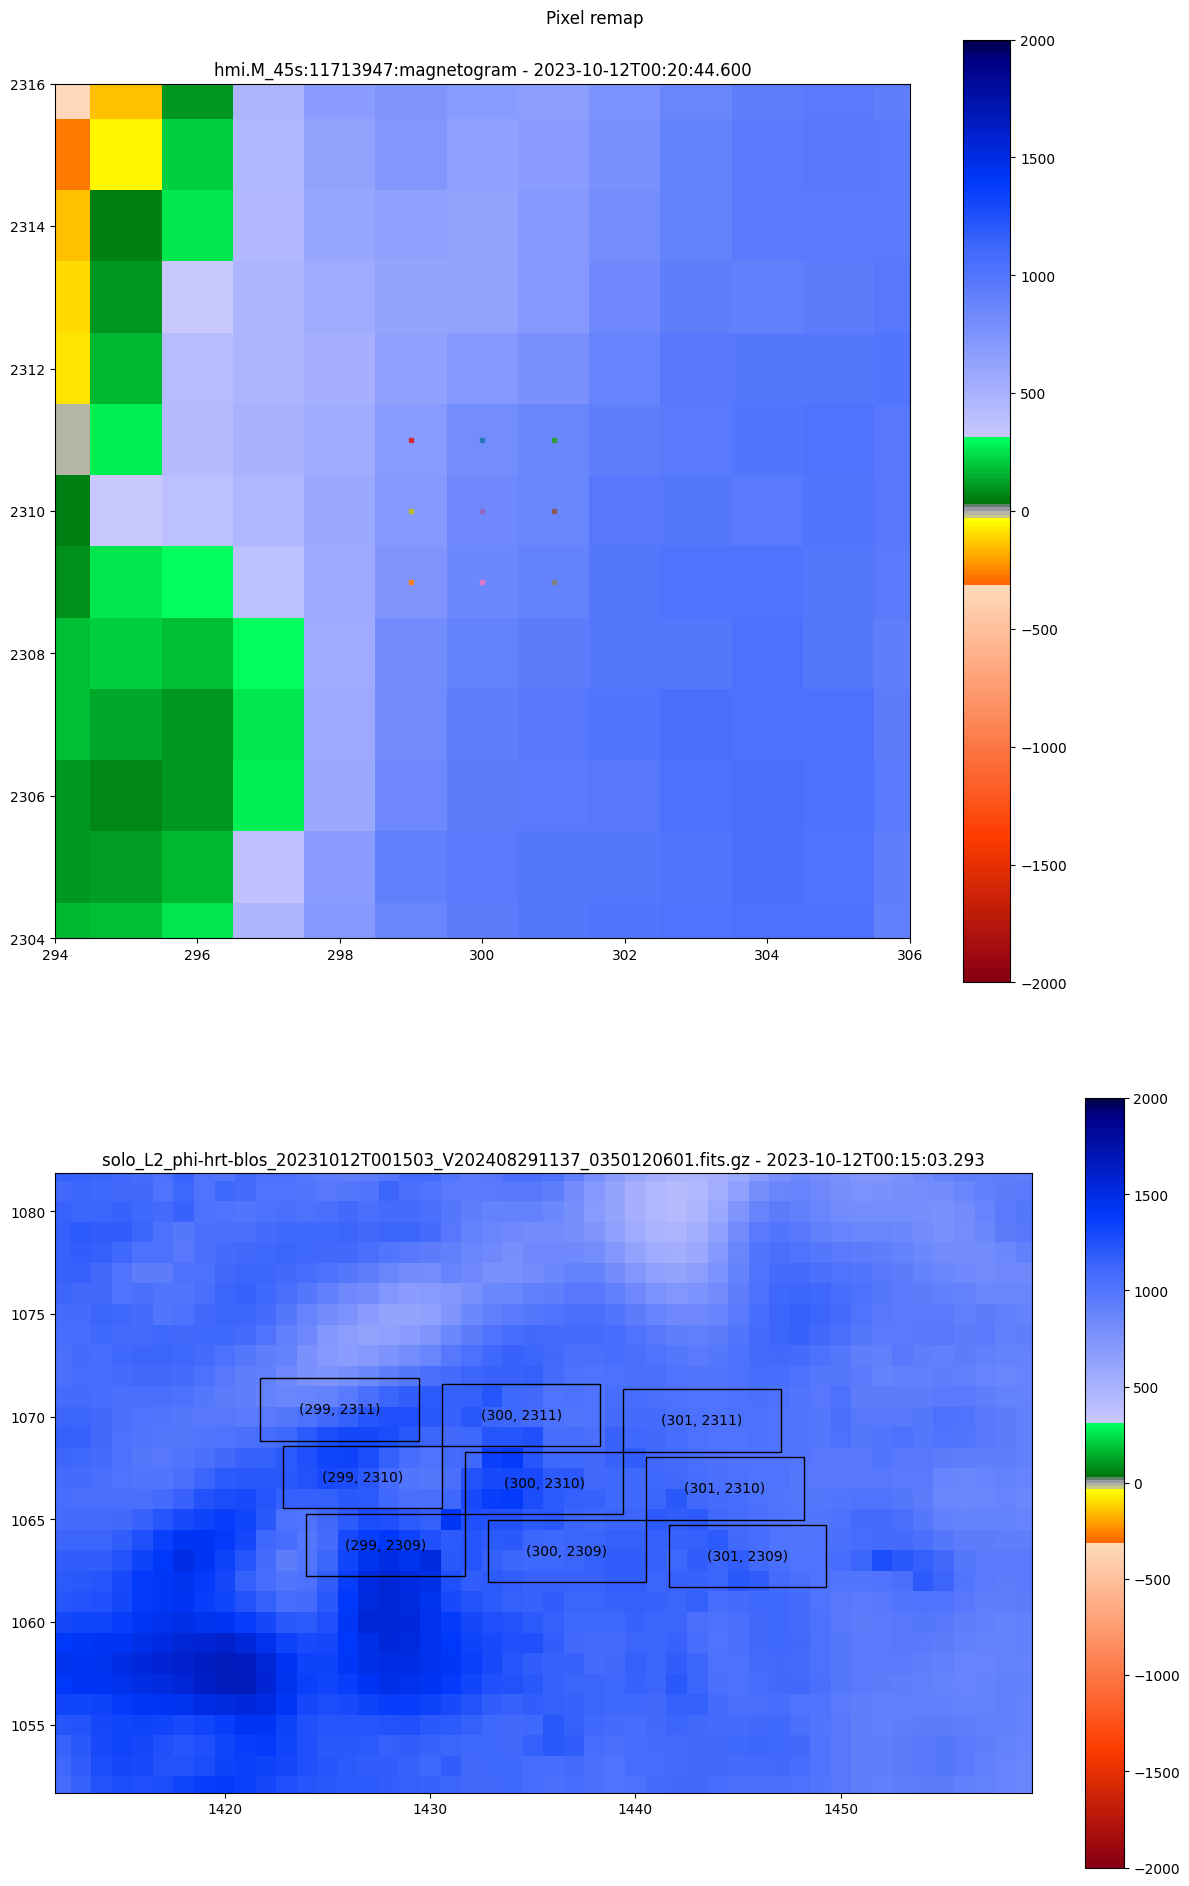

In [134]:
def plot_phi_out_dict(phi_out_dict,hmi_map,phi_map):
    hmi_pixels = list(set([(int(i.split('(')[1].split(')')[0].split(', ')[0]),\
                            int(i.split('(')[1].split(')')[0].split(', ')[1])) \
                           for i in phi_out_dict.keys()]))
    
    min_x_hmi_lim = min(set([i[0] for i in hmi_pixels]))-5
    max_x_hmi_lim = max(set([i[0] for i in hmi_pixels]))+5

    min_y_hmi_lim = min(set([i[1] for i in hmi_pixels]))-5
    max_y_hmi_lim = max(set([i[1] for i in hmi_pixels]))+5

    plt.figure(figsize=(12,20))
    plt.subplot(211)
    hmi_map.data[np.isnan(hmi_map.data)]=0
    
    hpc_coords = sunpy.map.all_coordinates_from_map(hmi_map)
    mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
        
    im=plt.imshow(hmi_map.data*~mask,origin="lower",cmap=magmap,vmin=-2000,vmax=2000) #[2000:2550,:500]
    plt.colorbar(im)
    plt.ylim(min_y_hmi_lim,max_y_hmi_lim)
    plt.xlim(min_x_hmi_lim,max_x_hmi_lim)
    for pix in hmi_pixels:
        plt.scatter(pix[0],pix[1],marker='X',s=10)
    drms_id = hmi_map.meta['drms_id']
    plt.title(f'{drms_id} - {hmi_map.date}')

    plt.subplot(212)
    im2=plt.imshow(phi_map.data,origin="lower",cmap=magmap,vmin=-2000,vmax=2000)

    ax=plt.gca()

    blks = []
    trks = []
    for pix in hmi_pixels:
        pix_dicts = {k: phi_out_dict[k] for k in phi_out_dict.keys() if str(pix) in k}
        blk = pix_dicts.get(f'HMI {pix} bleft')
        trk = pix_dicts.get(f'HMI {pix} tright')

        blks.append(blk)
        trks.append(trk)
        
        blx = blk[0]
        bly = blk[1] 
        trx = trk[0]
        tryy = trk[1] 
        rect = patches.Rectangle((blx, bly), trx-blx, tryy-bly, linewidth=1, facecolor='none', edgecolor='black')
        ax.add_patch(rect)

        centrex = blx + (trx-blx)/2 # obviously use a different formula for different shapes
        centrey = bly + (tryy-bly)/2
        plt.text(centrex, centrey,f'{pix}',horizontalalignment = 'center',verticalalignment = 'center')

    phi_x_min_lim = min(set([i[0] for i in blks]))-10
    phi_x_max_lim = max(set([i[0] for i in trks]))+10

    phi_y_min_lim = min(set([i[1] for i in blks]))-10
    phi_y_max_lim = max(set([i[1] for i in trks]))+10

    plt.xlim(phi_x_min_lim,phi_x_max_lim)
    plt.ylim(phi_y_min_lim,phi_y_max_lim)
    filename = phi_map.meta['filename']
    plt.title(f'{filename} - {phi_map.date}')
    plt.colorbar(im2,fraction=0.036)
    plt.suptitle('Pixel remap')
    plt.tight_layout()
    plt.show()

plot_phi_out_dict(phi_out_dict,hmi_121023_b,hrt_121023_b_map_shifttestn)

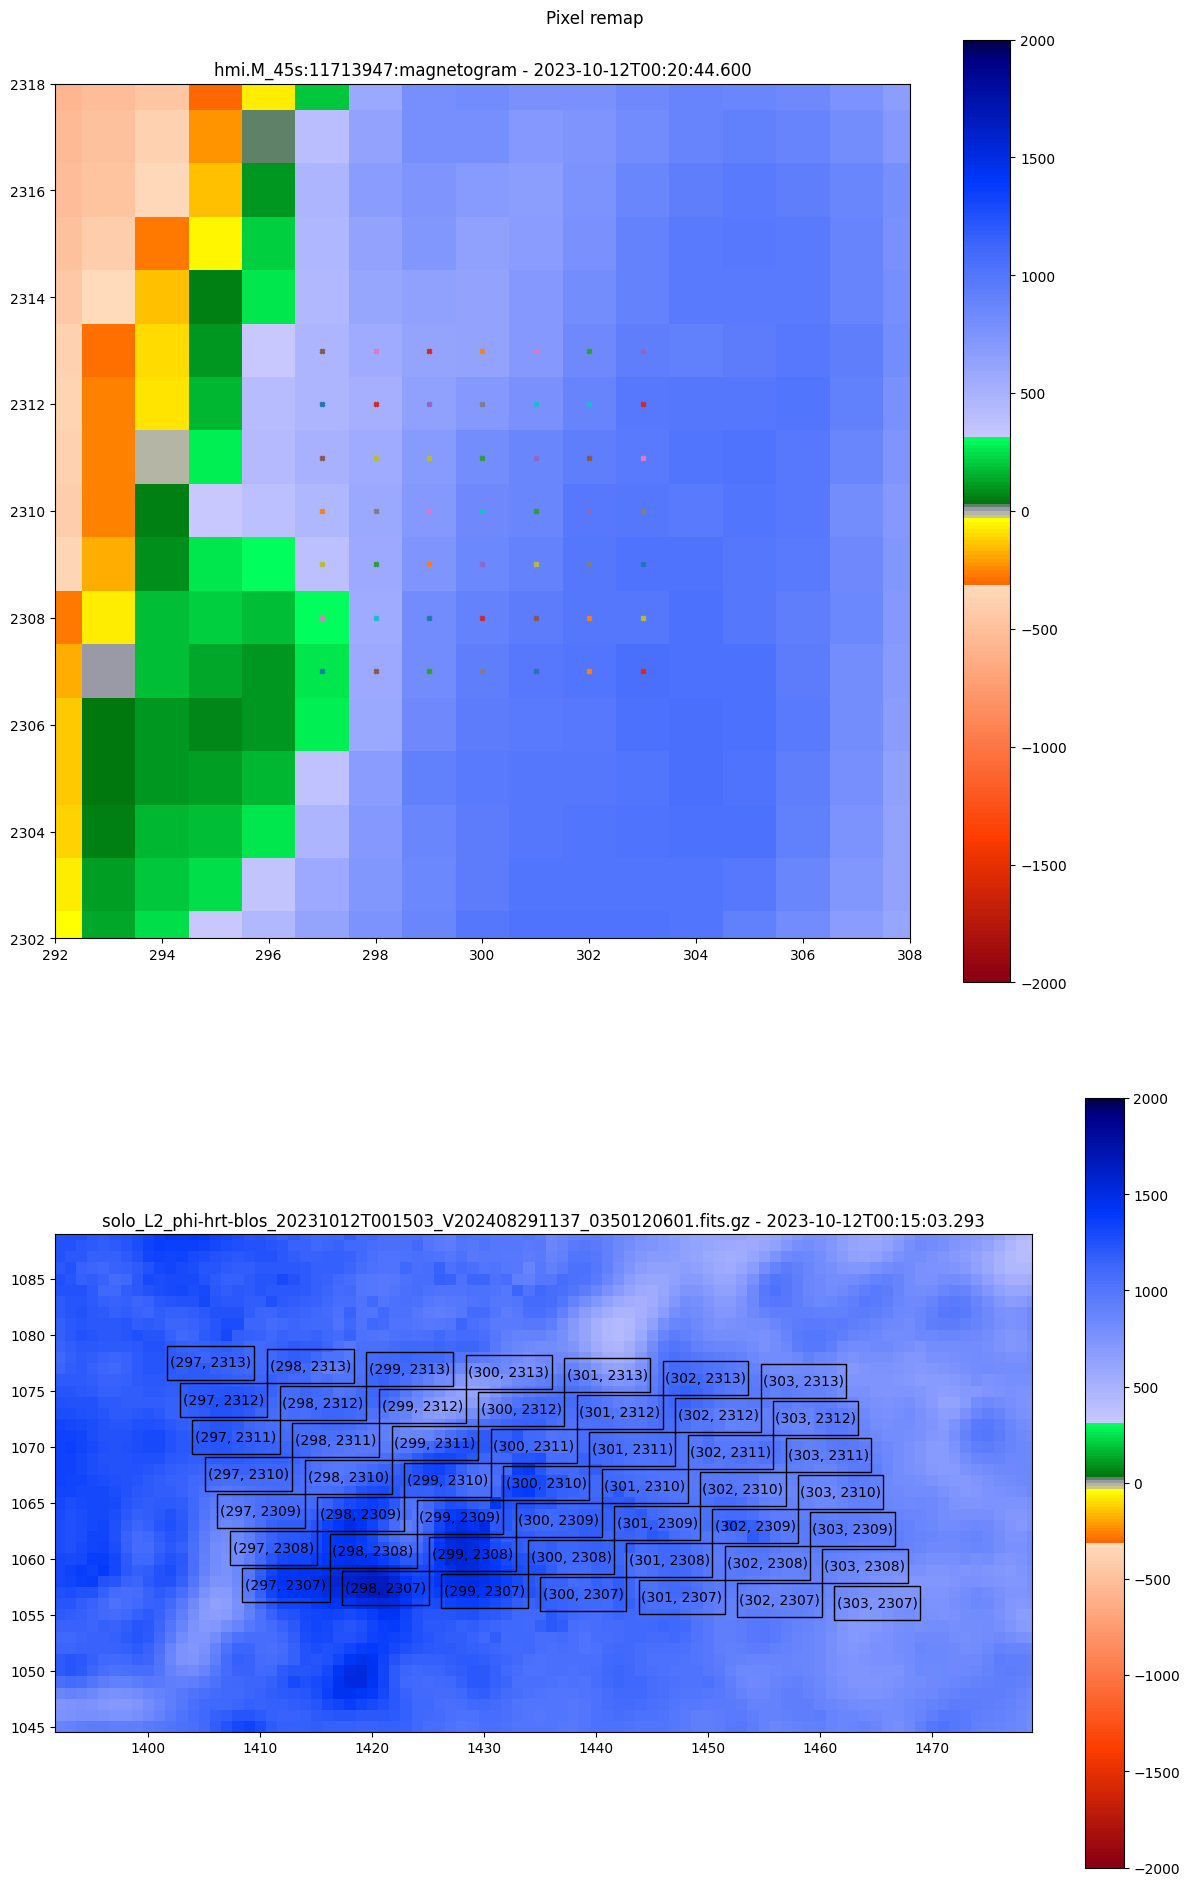

In [135]:
phi_out_dictl = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,300,2310,3)
plot_phi_out_dict(phi_out_dictl,hmi_121023_b,hrt_121023_b_map_shifttestn)

In [117]:
# time it for 100 HMI pixels

In [121]:
import datetime

start_time = datetime.datetime.now()

phi_out_test_100 = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,300,2310,4)
print(len(phi_out_test_100)/3)

end_time = datetime.datetime.now()

print('Time taken: ', (end_time-start_time))

81.0
Time taken:  0:00:05.666998


In [122]:
import datetime

start_time = datetime.datetime.now()

phi_out_test_1000 = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,300,2310,16)
print(len(phi_out_test_1000)/3)

end_time = datetime.datetime.now()

print('Time taken: ', (end_time-start_time))

1089.0
Time taken:  0:01:16.266021


In [126]:
# for this dataset, approx 150,000 HMI pixels that need to be remapped
# guess time = 1.25mins*150 =  3 hours
# using 60 cores on swan25, would take 3 minutes
# not very time efficient

In [127]:
# 1100*700 is the last size of the HMI map for this campaign
# 770,000 pixels
# so mulltiple of 5 times best case above
# but here, the phi map is foreshortened, so actually, so would be almost interpolating in X direction, but still binning down in y

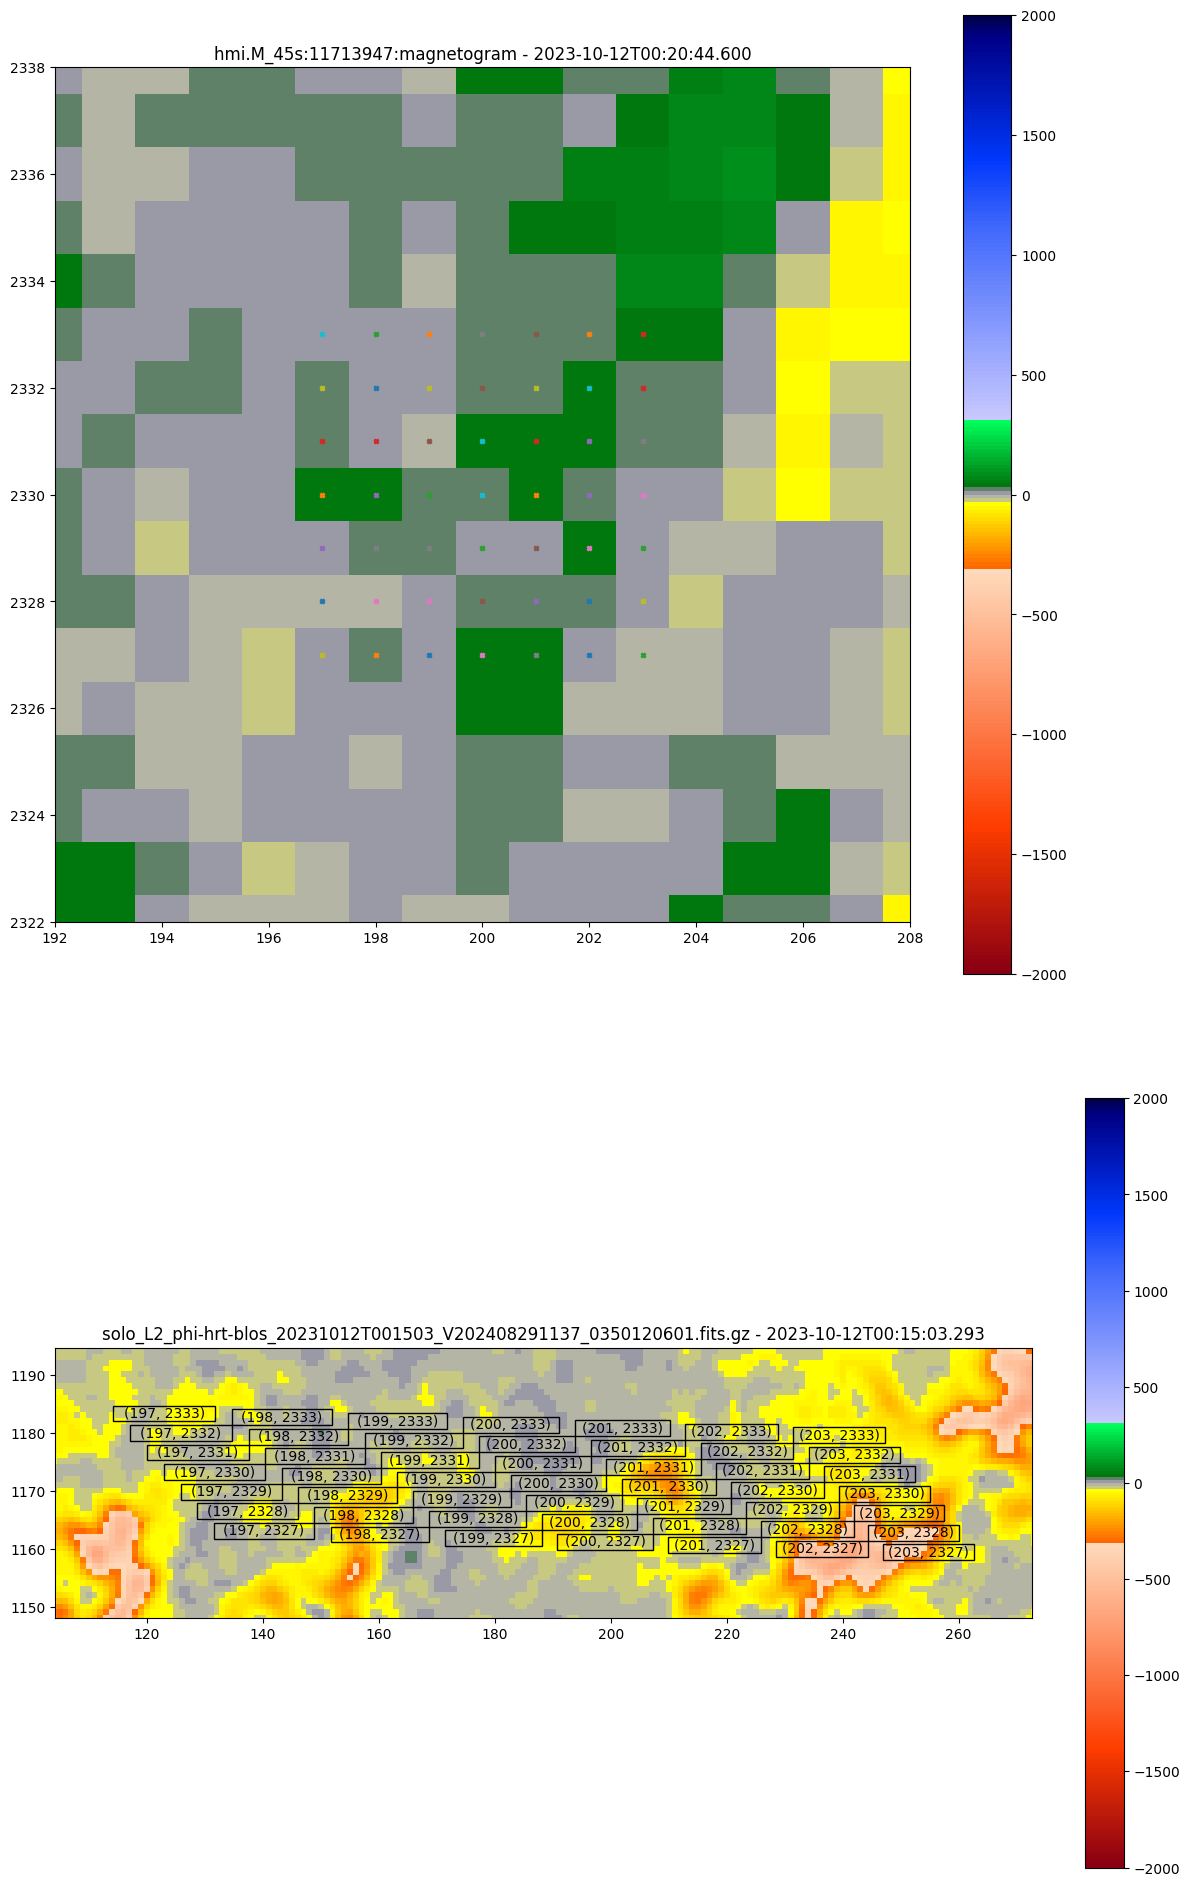

In [130]:
# test if gaps increase where more foreshortened

phi_out_dictlimb = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,200,2330,3)
plot_phi_out_dict(phi_out_dictlimb,hmi_121023_b,hrt_121023_b_map_shifttestn)

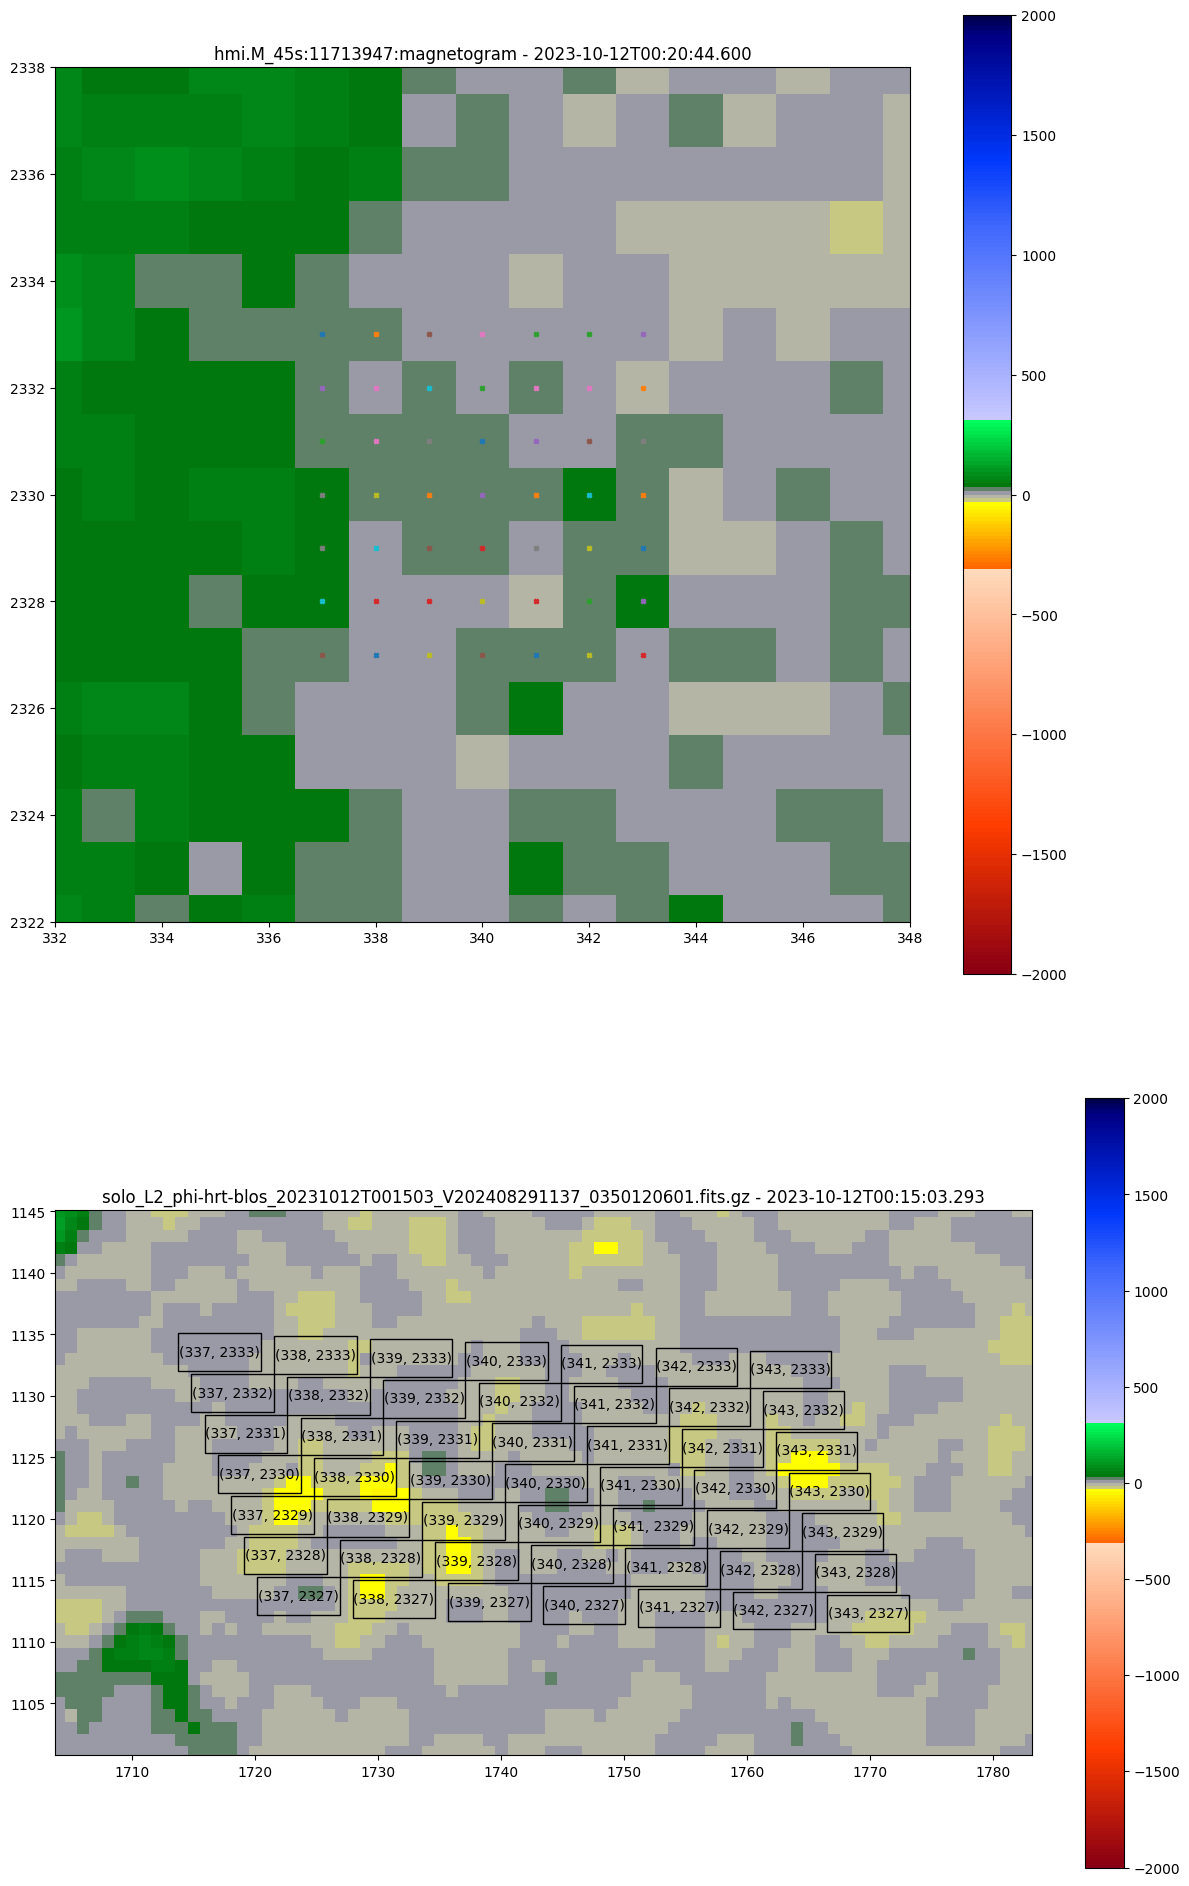

In [133]:
phi_out_dictlimb = get_phi_pixels_and_neighbours(hmi_121023_b,hrt_121023_b_map_shifttestn,340,2330,3)
plot_phi_out_dict(phi_out_dictlimb,hmi_121023_b,hrt_121023_b_map_shifttestn)